In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

def get_dataloaders(batch_size=16, seed=50):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 数据增强
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # 加载数据集
    data_dir = 'Aerial_Landscapes'
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    num_classes = len(dataset.classes)

    # 划分训练和验证集
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(seed)
    )

    # 加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    print(f"The number of classes: {num_classes}")
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")

    return train_loader, val_loader, num_classes

In [2]:
import timm

def get_model(num_classes=15):
    model = timm.create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=num_classes)
    return model

In [5]:
import torch
from torch import nn, optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    EPOCHS = 10
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4

    train_loader, val_loader, num_classes = get_dataloaders(batch_size=BATCH_SIZE)

    model = get_model(num_classes=num_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)
    scaler = GradScaler(device='cuda')

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    f1_scores = []
    best_acc = 0.0

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{EPOCHS}]"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # === 验证阶段 ===
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast(device_type='cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        f1 = f1_score(val_labels, val_preds, average='macro')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        f1_scores.append(f1)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f}, Val   Acc: {val_acc:.4f}, F1: {f1:.4f}")
        print(f"  Current LR: {scheduler.optimizer.param_groups[0]['lr']:.6f}")

        # === 保存最佳模型 ===
        if val_acc > best_acc:
            best_acc = val_acc
            print(f"New best accuracy: {val_acc:.4f}, saving model to swin_model.pth")
            torch.save(model.state_dict(), "swin_model.pth")

    print("\nTraining finished.")
    print(f"Best validation accuracy: {best_acc:.4f}")

    log_data = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

    with open("history_Swin.json", "w") as f:
        json.dump(log_data, f)

if __name__ == "__main__":
    main()

Using device: cuda
The number of classes: 15
Training set size: 9600
Validation set size: 2400


[Epoch 1/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:51<00:00,  2.60it/s]


Epoch 1:
  Train Loss: 0.2997, Train Acc: 0.9091
  Val   Loss: 0.1512, Val   Acc: 0.9542, F1: 0.9546
  Current LR: 0.000100
New best accuracy: 0.9542, saving model to swin_model.pth


[Epoch 2/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:49<00:00,  2.61it/s]


Epoch 2:
  Train Loss: 0.1151, Train Acc: 0.9632
  Val   Loss: 0.0871, Val   Acc: 0.9762, F1: 0.9763
  Current LR: 0.000100
New best accuracy: 0.9762, saving model to swin_model.pth


[Epoch 3/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:50<00:00,  2.61it/s]


Epoch 3:
  Train Loss: 0.0833, Train Acc: 0.9749
  Val   Loss: 0.1772, Val   Acc: 0.9487, F1: 0.9499
  Current LR: 0.000100


[Epoch 4/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:51<00:00,  2.59it/s]


Epoch 4:
  Train Loss: 0.0849, Train Acc: 0.9753
  Val   Loss: 0.0847, Val   Acc: 0.9733, F1: 0.9736
  Current LR: 0.000100


[Epoch 5/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:50<00:00,  2.61it/s]


Epoch 5:
  Train Loss: 0.0793, Train Acc: 0.9772
  Val   Loss: 0.1476, Val   Acc: 0.9613, F1: 0.9617
  Current LR: 0.000100


[Epoch 6/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:46<00:00,  2.65it/s]


Epoch 6:
  Train Loss: 0.0578, Train Acc: 0.9816
  Val   Loss: 0.1091, Val   Acc: 0.9675, F1: 0.9680
  Current LR: 0.000100


[Epoch 7/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [03:51<00:00,  2.59it/s]


Epoch 7:
  Train Loss: 0.0765, Train Acc: 0.9792
  Val   Loss: 0.1235, Val   Acc: 0.9658, F1: 0.9661
  Current LR: 0.000100


[Epoch 8/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [05:03<00:00,  1.98it/s]


Epoch 8:
  Train Loss: 0.0570, Train Acc: 0.9827
  Val   Loss: 0.0766, Val   Acc: 0.9758, F1: 0.9765
  Current LR: 0.000100


[Epoch 9/10]: 100%|██████████████████████████████████████████████████████████████████| 600/600 [05:19<00:00,  1.88it/s]


Epoch 9:
  Train Loss: 0.0552, Train Acc: 0.9833
  Val   Loss: 0.1160, Val   Acc: 0.9663, F1: 0.9667
  Current LR: 0.000100


[Epoch 10/10]: 100%|█████████████████████████████████████████████████████████████████| 600/600 [05:02<00:00,  1.98it/s]


Epoch 10:
  Train Loss: 0.0498, Train Acc: 0.9838
  Val   Loss: 0.0794, Val   Acc: 0.9762, F1: 0.9761
  Current LR: 0.000100

Training finished.
Best validation accuracy: 0.9762


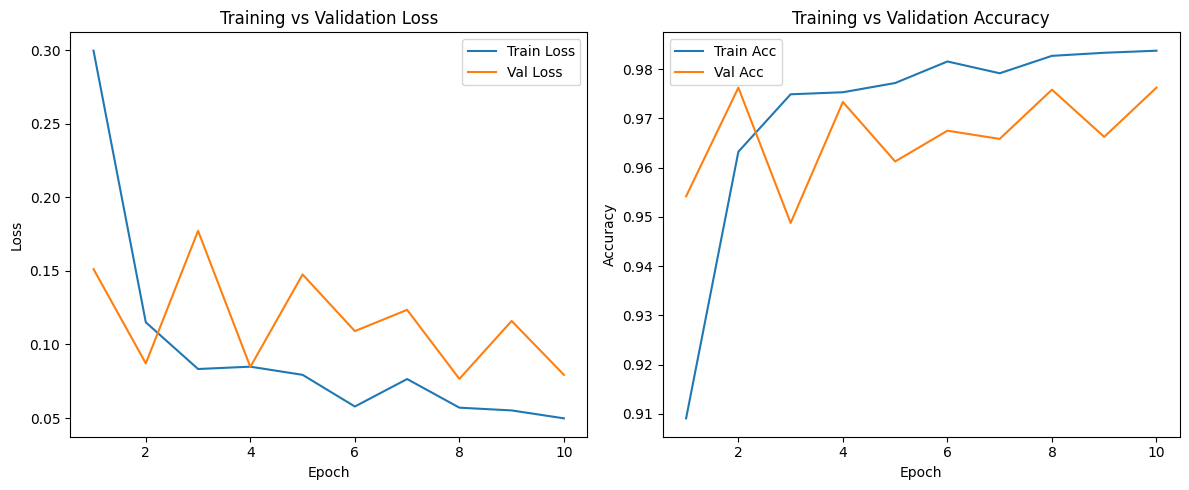

In [7]:
import json
import matplotlib.pyplot as plt

# === 读取日志 ===
with open("history_Swin.json", "r") as f:
    log = json.load(f)

train_losses = log["train_losses"]
val_losses = log["val_losses"]
train_accuracies = log["train_accuracies"]
val_accuracies = log["val_accuracies"]

epochs = range(1, len(train_losses) + 1)

# === 绘制 Loss 图像 ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# === 绘制 Accuracy 图像 ===
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Acc")
plt.plot(epochs, val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, val_loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # === 1. 打印整体评估报告 ===
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # === 2. 混淆矩阵 ===
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

The number of classes: 15
Training set size: 9600
Validation set size: 2400

Classification Report:
              precision    recall  f1-score   support

 Agriculture     0.9541    1.0000    0.9765       187
     Airport     0.9810    0.9810    0.9810       158
       Beach     0.9866    0.9671    0.9767       152
        City     0.9806    0.9682    0.9744       157
      Desert     0.9461    1.0000    0.9723       158
      Forest     0.9742    0.9934    0.9837       152
   Grassland     0.9868    0.9677    0.9772       155
     Highway     1.0000    0.9603    0.9797       151
        Lake     0.9615    0.9804    0.9709       153
    Mountain     0.9932    0.9125    0.9511       160
     Parking     0.9878    0.9818    0.9848       165
        Port     1.0000    0.9752    0.9874       161
     Railway     0.9679    0.9742    0.9711       155
 Residential     0.9367    1.0000    0.9673       148
       River     0.9838    0.9681    0.9759       188

    accuracy                      

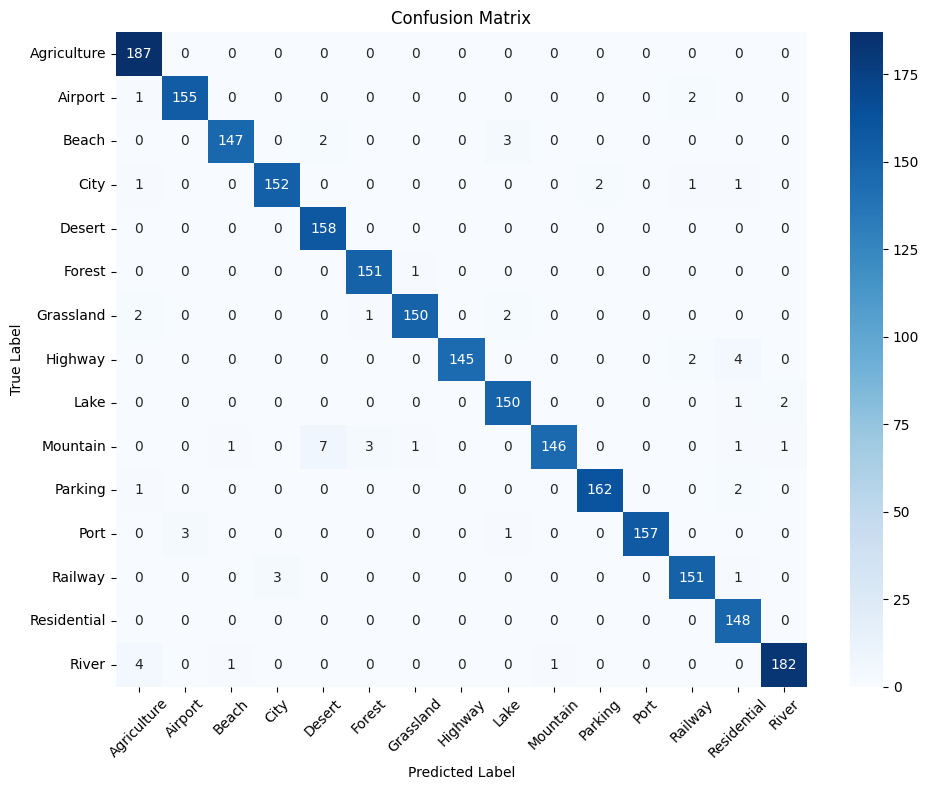

In [28]:
train_loader, val_loader, num_classes = get_dataloaders(batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = get_model(num_classes=15).to(device)

model.load_state_dict(torch.load("swin_model.pth", map_location=device))
model.to(device)

class_names = val_loader.dataset.dataset.classes

evaluate_model(model, val_loader, class_names, device)